### Compare the performance of the model trained on augmented data (basic) and raw data : PAMAP

Gyuyeon Lim (lky473736)

- **Reference**
    - https://github.com/uchidalab/time_series_augmentation/blob/master/utils/augmentation.py
    - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb
    
<br>

- **Data shape**
    - window size : 100 (will use way of sliding window)

- **Model**
    - CNN-LSTM
    - U-net
    - transformer-encoder

- **Augmentation**
    - 

In [22]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [24]:
# ignoring future warnings
import warnings
warnings.simplefilter('ignore')

---

In [25]:
# column names of the data

columns = ['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3D_acceleration_16_x',  'hand_3D_acceleration_16_y',
         'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x', 'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z', 'hand_3D_gyroscope_x',
         'hand_3D_gyroscope_y',  'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
         'hand_4D_orientation_x', 'hand_4D_orientation_y', 'hand_4D_orientation_z', 'hand_4D_orientation_w', 'chest_temperature', 'chest_3D_acceleration_16_x',
         'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y',  'chest_3D_acceleration_6_z',
         'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z', 'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
         'chest_3D_magnetometer_z', 'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w',
         'ankle_temperature', 'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
         'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
         'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x', 'ankle_4D_orientation_y',
         'ankle_4D_orientation_z', 'ankle_4D_orientation_w']

In [26]:
# data load

def load_data() :
    root = os.path.join('..', '..', '..', 'data', 'PAMAP', 'PAMAP')
    data_list = []  
    
    for i in range(101, 106) : # 101.dat, 102.dat, 103.dat, 104.dat, 105.dat
        '''
            there is 10 files in PAMAP
            but doing all files at this, this must has the flooded issue of memory
            so i will use only 5 files
        '''
        path = os.path.join(root, f"{i}.dat")
        df = pd.read_table(path, header=None, sep='\s+')
        
        print (f"{i}.dat is {df.shape}")
        
        df.columns = columns
        df['id'] = i
        
        print (f"{len(df['activity_id'].unique())}")
        
        data_list.append(df)  

    #  data = pd.concat(data_list, ignore_index=True)
    # data.reset_index(drop=True, inplace=True)
    
    return data_list

df_list = load_data()

101.dat is (376417, 54)
13
102.dat is (447000, 54)
13
103.dat is (252833, 54)
9
104.dat is (329576, 54)
12
105.dat is (374783, 54)
13


In [27]:
# concatenation the dataframe

df = pd.concat(df_list, ignore_index=True)
df.reset_index(drop=True, inplace=True)

df

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.600740,3.51048,2.43954,8.761650,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.14380,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.565600,3.66179,2.39494,8.550810,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.52530,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.601070,3.54898,2.30514,8.536440,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.39990,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.528530,3.66021,2.33528,8.536220,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.39560,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.831220,3.70000,2.23055,8.597410,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.26940,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780604,3753.48,24,NaN,33.8125,-2.43654,-0.655505,-4.72814,-2.35051,-0.635334,-4.91018,...,0.242415,0.934088,-46.2344,-5.06546,-2.71978,0.469287,0.059003,0.849955,0.232087,105
1780605,3753.49,24,NaN,33.8125,-2.72148,-0.270088,-4.31035,-2.40802,-0.589344,-4.62331,...,0.084749,0.792861,-46.7418,-4.90974,-2.15442,0.470816,0.060165,0.850537,0.226494,105
1780606,3753.50,24,NaN,33.8125,-2.69395,0.229159,-3.61885,-2.50771,-0.376741,-4.14045,...,-0.077675,0.563650,-46.7372,-4.90871,-1.72891,0.471456,0.059840,0.851859,0.220192,105
1780607,3753.51,24,NaN,33.8125,-2.62461,0.729121,-2.81126,-2.46646,0.167377,-3.35644,...,-0.093296,0.363001,-46.9957,-4.89665,-2.01350,0.471882,0.057498,0.853724,0.212546,105


In [28]:
# A function that checks the percentage of missing values,unique values,percentage of one catagory values and type against each column.

'''
    Unique_values : the component that not null
    Missing values : null
    Peercentage of Missing values : number of null / number of all samples
    Data Type : dtype of each cols
'''

def statistics(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing values', 'Percentage of Missing Values', 'Data Type'])
    stats_df.set_index('Feature', drop=True, inplace=True)
    stats_df.drop(stats_df[stats_df['Missing values'] == 0].index, axis=0, inplace=True)
    stats_df.sort_values('Percentage of Missing Values', ascending=False, inplace=True)
    return stats_df

statistics(df).T

Feature,heart_rate,hand_3D_gyroscope_z,hand_temperature,hand_4D_orientation_z,hand_4D_orientation_y,hand_4D_orientation_x,hand_3D_magnetometer_z,hand_3D_magnetometer_y,hand_3D_magnetometer_x,hand_4D_orientation_w,...,chest_3D_acceleration_6_y,chest_3D_gyroscope_x,chest_4D_orientation_z,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_3D_gyroscope_y
Unique_values,127,1338175,130,901491,953022,788561,886435,861768,930699,975161,...,623957,1314554,1002273,1303028,1052684,567411,971211,690583,743287,1362079
Missing values,1617991,8460,8460,8460,8460,8460,8460,8460,8460,8460,...,1604,1604,1604,1604,1604,1604,1604,1604,1604,1604
Percentage of Missing Values,90.867282,0.475118,0.475118,0.475118,0.475118,0.475118,0.475118,0.475118,0.475118,0.475118,...,0.090082,0.090082,0.090082,0.090082,0.090082,0.090082,0.090082,0.090082,0.090082,0.090082
Data Type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [29]:
# Function that fills the null values with either the mean or median based on a normal test

def fillnull(columns, df=df):
    from scipy.stats import normaltest
    # Iterating Numerical columns
    for i in columns:
        # Finding Normality of feature
        st, p = normaltest(df[i].dropna())

        # Checking if normal or not
        if p > 0.05:
            # Filling with mean if normal
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            # Filling with median if not normal
            df[i].fillna(df[i].median(), inplace=True)
            
# Taking out column names that have null values
num_cols = statistics(df).index

# Applying function
fillnull(num_cols)

In [30]:
# Acitvity_id = 0 is not an valid activity so it should be dropped
df.drop(df[df['activity_id']==0].index, inplace=True, axis=0)

In [31]:
# As it can be seen here there is no null values any longer in the dataframe.
print (df.isnull().sum())
print (~any(df.isnull()))

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [32]:
# information of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191507 entries, 2928 to 1780608
Data columns (total 55 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   time_stamp                  1191507 non-null  float64
 1   activity_id                 1191507 non-null  int64  
 2   heart_rate                  1191507 non-null  float64
 3   hand_temperature            1191507 non-null  float64
 4   hand_3D_acceleration_16_x   1191507 non-null  float64
 5   hand_3D_acceleration_16_y   1191507 non-null  float64
 6   hand_3D_acceleration_16_z   1191507 non-null  float64
 7   hand_3D_acceleration_6_x    1191507 non-null  float64
 8   hand_3D_acceleration_6_y    1191507 non-null  float64
 9   hand_3D_acceleration_6_z    1191507 non-null  float64
 10  hand_3D_gyroscope_x         1191507 non-null  float64
 11  hand_3D_gyroscope_y         1191507 non-null  float64
 12  hand_3D_gyroscope_z         1191507 non-null  float64
 13 

In [33]:
# see that target is 0-based

print (df['activity_id'].unique())


'''
    we need to encoding now to 0-based
    (labelencoding)
'''

[ 1  2  3 17 16 12 13  4  7  6  5 24]


'\n    we need to encoding now to 0-based\n    (labelencoding)\n'

In [34]:
# label encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['activity_id'] = encoder.fit_transform(df['activity_id'])

print (df['activity_id'].unique())

[ 0  1  2 10  9  7  8  3  6  5  4 11]


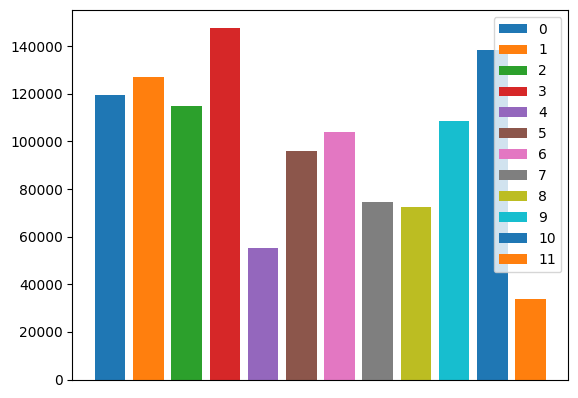

activity_id
3     147787
10    138457
1     126942
0     119407
2     114664
9     108431
6     103808
5      95959
7      74596
8      72399
4      55150
11     33907
Name: count, dtype: int64


"\n    This situation solved using SMOTE and oversampling random position at records before bunches of documents.\n    But this data is time-series, has depandancy of time.\n    \n    so i will the original augmentation that Terry Taewoong Um offered. \n    That file will be uploaded at './augmentation'\n"

In [35]:
# activity_id - countplot, value_count

import math

target = np.unique(df['activity_id'])

width = 1
for compo in target : 
    plt.bar(width, len(df[df['activity_id'] == compo]), 
            label=compo)
    width += 1
    
plt.xticks([], [])

plt.legend()
plt.show()

print (df['activity_id'].value_counts())

'''
    This situation solved using SMOTE and oversampling random position at records before bunches of documents.
    But this data is time-series, has depandancy of time.
    
    so i will the original augmentation that Terry Taewoong Um offered. 
    That file will be uploaded at './augmentation'
'''

In [36]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

X = df[[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y = df['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

scaled_df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
scaled_df['activity_id'] = y.values

scaled_df 

,time_stamp,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,...,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id,activity_id
0,-1.511899,0.025599,-1.335739,1.165974,0.667456,0.509138,1.153912,0.721969,0.511290,-0.018115,...,-0.007186,-1.403480,-1.652451,-3.639552,1.658053,0.061127,-0.895793,0.158995,-1.365475,0
1,-1.511890,0.025599,-1.335739,1.178712,0.549345,0.550260,1.158347,0.641905,0.515457,-0.142765,...,-0.005011,-1.392634,-1.628131,-3.639358,1.658053,0.061127,-0.895793,0.158995,-1.365475,0
2,-1.511881,0.025599,-1.335739,1.178536,0.445999,0.570868,1.157675,0.547066,0.515737,-0.192436,...,-0.010578,-1.365037,-1.604186,-3.651275,1.658053,0.061127,-0.895793,0.158995,-1.365475,0
3,-1.511872,0.025599,-1.335739,1.166423,0.446242,0.590725,1.149760,0.467124,0.539641,-0.158594,...,0.005694,-1.386272,-1.663147,-3.615859,1.658053,0.061127,-0.895793,0.158995,-1.365475,0
4,-1.511863,-1.517477,-1.335739,1.180224,0.468630,0.641306,1.147352,0.464194,0.559371,-0.066801,...,-0.011316,-1.358189,-1.664028,-3.616092,1.658053,0.061127,-0.895793,0.158995,-1.365475,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191502,1.834312,0.025599,0.581406,0.393008,-1.073161,-2.190360,0.394122,-1.081483,-2.278103,-2.896949,...,0.469399,-0.658382,-0.230610,-0.947115,0.117552,0.169896,1.899105,0.647290,1.350610,11
1191503,1.834321,0.025599,0.581406,0.345661,-0.998076,-2.081029,0.384617,-1.072457,-2.203190,-3.387448,...,0.397208,-0.683800,-0.223647,-0.919762,0.121990,0.172038,1.901018,0.635522,1.350610,11
1191504,1.834330,0.025599,0.581406,0.350236,-0.900814,-1.900071,0.368142,-1.030732,-2.077096,-3.706136,...,0.280041,-0.683570,-0.223601,-0.899175,0.123848,0.171440,1.905366,0.622263,1.350610,11
1191505,1.834339,0.025599,0.581406,0.361758,-0.803413,-1.688733,0.374959,-0.923945,-1.872360,-3.880426,...,0.177475,-0.696519,-0.223062,-0.912944,0.125084,0.167121,1.911498,0.606177,1.350610,11


------

#### Original (no augmentation)